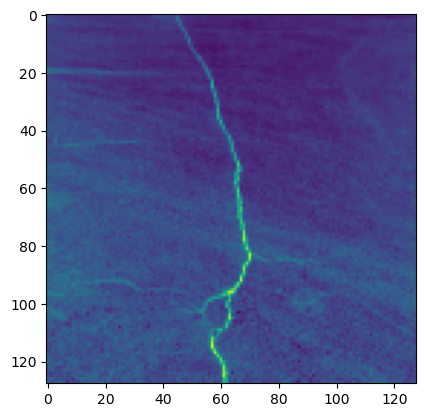

In [1]:
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import cv2

filenames = glob('crack_segmentation_dataset/images/DeepCrack*.jpg')
y_filenames = glob('crack_segmentation_dataset/masks/CFD*.jpg')
X = np.random.choice(filenames)
img = cv2.imread(X, -1)
img = cv2.resize(img, (128, 128), interpolation=cv2.INTER_AREA)
img = 255-cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
plt.figure()
plt.imshow(img)
plt.show()

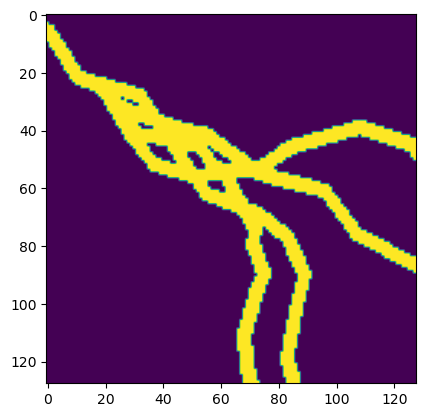

In [2]:
import importlib
import cyclegan
cyclegan = importlib.reload(cyclegan)

crack = cyclegan.DataGenerator([],[], 128, 128).generate_crack()

plt.figure()
plt.imshow(crack)
plt.show()

In [12]:
import importlib
import cyclegan
cyclegan = importlib.reload(cyclegan)

filenames = glob('crack_segmentation_dataset/images/DeepCrack*.jpg')
y_filenames = glob('crack_segmentation_dataset/masks/CFD*.jpg')

cyclegan_model = cyclegan.CycleGAN(128, 128)
cyclegan_model.data_generator = cyclegan.DataGenerator(filenames,y_filenames, 128, 128)

In [13]:
cyclegan_model.test_model(2)

1/1 [==============================] - 0s 20ms/step


In [4]:
cyclegan_model = cyclegan.CycleGAN(128, 128)

In [5]:
cyclegan_model.test_model(1)

AttributeError: 'NoneType' object has no attribute 'generate_real_samples'

In [4]:
from tensorflow.keras.models import load_model

cyclegan_model.g_model_AB = load_model('initial_models2/g_model_AB.h5')
cyclegan_model.g_model_BA = load_model('initial_models2/g_model_BA.h5')

In [5]:
def normalise_image(img):

    return ((img - np.amin(img)) / (np.amax(img) - np.amin(img)))*2-1

# A 2 B

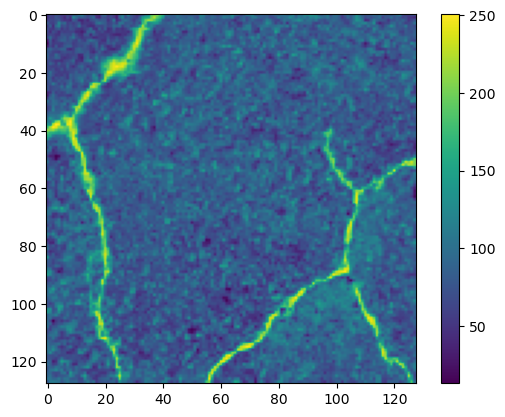

1/1 [==============================] - 6s 6s/step


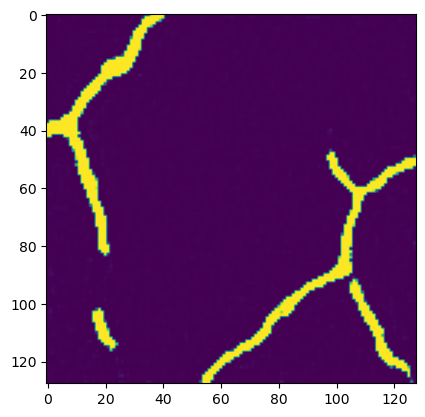

In [6]:
plt.figure()
plt.imshow(img)
plt.colorbar()
plt.show()

pred = cyclegan_model.g_model_AB.predict(np.expand_dims(normalise_image(img), axis=[0, -1]))

plt.figure()
plt.imshow(np.squeeze(pred))
plt.show()

# B 2 A

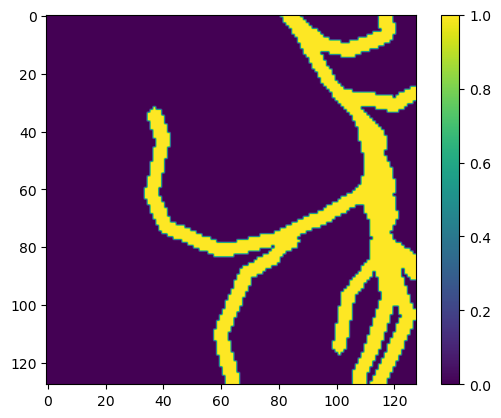

1/1 [==============================] - 0s 24ms/step


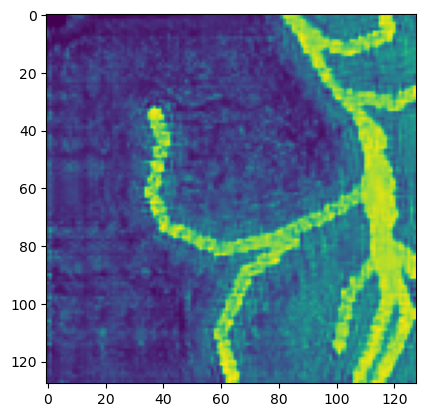

In [10]:
plt.figure()
plt.imshow(crack)
plt.colorbar()
plt.show()

pred_BA = cyclegan_model.g_model_BA.predict(np.expand_dims(normalise_image(crack), axis=[0, -1]))

plt.figure()
plt.imshow(np.squeeze(pred_BA))
plt.show()

In [10]:
type(pred_BA)

numpy.ndarray

# Gradio Experiment

In [16]:
import gradio as gr

def function(img):
    print('image received')
    print(type(img))
    print(np.shape(img))
    img = cv2.resize(img, (128, 128), interpolation=cv2.INTER_AREA)
    img = ((img - np.amin(img)) / (np.amax(img) - np.amin(img)))*2-1
    img = np.expand_dims(img, axis=[0, -1])
    pred_BA = cyclegan_model.g_model_BA.predict(img)
    pred_BA = np.squeeze(pred_BA)

    pred_BA = (pred_BA - np.amin(pred_BA)) / (np.amax(pred_BA) - np.amin(pred_BA))

    return pred_BA

gr.Interface(fn=function, 
             inputs=cp,
             outputs=gr.outputs.Image(type="numpy", label="Output"),
             live=True).launch()


c:\Users\David\miniconda3\envs\tf_env\lib\site-packages\gradio\outputs.py:42: UserWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  warnings.warn(


Hint: Set streaming=True for Image component to use live streaming.
Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


(<gradio.routes.App at 0x2b1d1d97550>, 'http://127.0.0.1:7860/', None)

image received
<class 'numpy.ndarray'>
(128, 128)
1/1 [==============================] - 0s 29ms/step
image received
<class 'numpy.ndarray'>
(128, 128)
1/1 [==============================] - 0s 21ms/step
image received
<class 'numpy.ndarray'>
(128, 128)
1/1 [==============================] - 0s 20ms/step
image received
<class 'numpy.ndarray'>
(128, 128)
1/1 [==============================] - 0s 20ms/step
image received
<class 'numpy.ndarray'>
(128, 128)
1/1 [==============================] - 0s 22ms/step
image received
<class 'numpy.ndarray'>
(128, 128)
1/1 [==============================] - 0s 22ms/step
image received
<class 'numpy.ndarray'>
(128, 128)
1/1 [==============================] - 0s 21ms/step
image received
<class 'numpy.ndarray'>
(128, 128)
1/1 [==============================] - 0s 20ms/step
image received
<class 'numpy.ndarray'>
(128, 128)
1/1 [==============================] - 0s 20ms/step
image received
<class 'numpy.ndarray'>
(128, 128)
1/1 [===========================

Traceback (most recent call last):
  File "c:\Users\David\miniconda3\envs\tf_env\lib\site-packages\gradio\routes.py", line 284, in run_predict
    output = await app.blocks.process_api(
  File "c:\Users\David\miniconda3\envs\tf_env\lib\site-packages\gradio\blocks.py", line 950, in process_api
    result = await self.call_function(fn_index, inputs, iterator)
  File "c:\Users\David\miniconda3\envs\tf_env\lib\site-packages\gradio\blocks.py", line 792, in call_function
    prediction = await anyio.to_thread.run_sync(
  File "c:\Users\David\miniconda3\envs\tf_env\lib\site-packages\anyio\to_thread.py", line 31, in run_sync
    return await get_asynclib().run_sync_in_worker_thread(
  File "c:\Users\David\miniconda3\envs\tf_env\lib\site-packages\anyio\_backends\_asyncio.py", line 937, in run_sync_in_worker_thread
    return await future
  File "c:\Users\David\miniconda3\envs\tf_env\lib\site-packages\anyio\_backends\_asyncio.py", line 867, in run
    result = context.run(func, *args)
  File "C:

image received
<class 'numpy.ndarray'>
(128, 128)
1/1 [==============================] - 0s 23ms/step
image received
<class 'numpy.ndarray'>
(128, 128)
1/1 [==============================] - 0s 20ms/step
image received
<class 'numpy.ndarray'>
(128, 128)
1/1 [==============================] - 0s 21ms/step
image received
<class 'numpy.ndarray'>
(128, 128)
1/1 [==============================] - 0s 20ms/step
image received
<class 'numpy.ndarray'>
(128, 128)
1/1 [==============================] - 0s 19ms/step
image received
<class 'numpy.ndarray'>
(128, 128)
1/1 [==============================] - 0s 21ms/step
image received
<class 'numpy.ndarray'>
(128, 128)
1/1 [==============================] - 0s 21ms/step
image received
<class 'numpy.ndarray'>
(128, 128)
1/1 [==============================] - 0s 21ms/step
image received
<class 'numpy.ndarray'>
(128, 128)
1/1 [==============================] - 0s 19ms/step
image received
<class 'numpy.ndarray'>
(128, 128)
1/1 [===========================

In [13]:
gr.Sketchpad(kwargs={'shape':(128, 128)})

c:\Users\David\miniconda3\envs\tf_env\lib\site-packages\gradio\deprecation.py:43: UserWarning: You have unused kwarg parameters in Sketchpad, please remove them: {'kwargs': {'shape': (128, 128)}}
  warnings.warn(


image

In [14]:
sp = gr.Sketchpad()
sp.shape = (1024, 1024)

In [15]:
cp = gr.Image(tool='color-sketch', source='canvas', image_mode='L')
cp.shape = (128, 128)

In [ ]:
output_image = gr.Image(image_mode='L', shape=(128, 128))